In [157]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
import category_encoders as ce
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
import joblib

### 1. Загрузка данных

In [92]:
df = pd.read_pickle(r'test_data.pickle')

In [93]:
df.head(10)

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,doctor_specialization,doctor_speciality,physiotherapy_type,diagnostics_type,laboratory_type,consultation_type,hospital_id,service_rownum,quantity_service,sum_rub_service
0,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,5,1,220
1,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,6,1,244
2,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,7,1,216
3,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,8,1,454
4,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,9,1,229
5,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - биохим.,NaN,35002198,10,1,154
6,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,УЗИ,NaN,NaN,35002198,11,1,2239
7,100134420,100134420.2.1,2022-10-14,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - заб. мат.,NaN,35002198,12,1,294
8,100134420,100134420.2.1,2022-10-24,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Поликлиника,...,NaN,NaN,NaN,NaN,NaN,NaN,35002198,15,1,411
9,100134420,100134420.2.1,2022-10-24,2022-10-13,2022-10-25,13,Completed,Не КМ,Очно,Лаборатория,...,NaN,NaN,NaN,NaN,Лаб. усл. - общекл.,NaN,35002198,16,1,298


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999992 entries, 0 to 999999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   user_id                999992 non-null  int64 
 1   session_id             999992 non-null  object
 2   date_service           999992 non-null  object
 3   session_start_date     999992 non-null  object
 4   session_end_date       999992 non-null  object
 5   session_length         999992 non-null  int64 
 6   session_status         999992 non-null  object
 7   segment                999992 non-null  object
 8   channel                999992 non-null  object
 9   subchannel             998097 non-null  object
 10  service_category       776154 non-null  object
 11  doctor_specialization  262912 non-null  object
 12  doctor_speciality      276145 non-null  object
 13  physiotherapy_type     95930 non-null   object
 14  diagnostics_type       106657 non-null  object
 15  

### 2. Очистка данных и заполнение пропусков

In [95]:
# Выведем список признаков с пропусками, отсортированный по возрастанию количества пропусков 

def series_cols_with_null (df: pd.DataFrame) -> pd.Series:
    cols_null_percent = df.isnull().mean() * 100
    cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
    return cols_with_null

In [96]:
series_cols_with_null(df)

physiotherapy_type       90.406923
diagnostics_type         89.334215
consultation_type        76.728214
doctor_specialization    73.708590
doctor_speciality        72.385279
laboratory_type          70.580365
service_category         22.383979
subchannel                0.189502
dtype: float64

#### 2.1. Поиск и удаление дубликатов

In [97]:
#Количество дубликатов
print(df.shape)
df[df.duplicated()].shape
df.drop_duplicates(inplace = True)
print(df.shape)

(999992, 21)
(999992, 21)


#### 2.2. Заполним пропуски в признаках 

Заполним пропуски в признаке service_category

In [98]:
df['service_category'].value_counts()

Лабораторная диагностика        294194
Приемы или консультации         276145
Инструментальная диагностика    106657
Физиотерапия                     95930
Услуги сопровождения              3228
Name: service_category, dtype: int64

Возможно, пропуски в категориях услуг связаны с тем, что предоставленную услугу нельзя было отнести к какой-либо из представленных категорий, поэтому обозначим пропуски в этом столбце категорией "Иные услуги".

In [99]:
df['service_category']=df['service_category'].fillna('Иные услуги')
df['service_category'].value_counts()

Лабораторная диагностика        294194
Приемы или консультации         276145
Иные услуги                     223838
Инструментальная диагностика    106657
Физиотерапия                     95930
Услуги сопровождения              3228
Name: service_category, dtype: int64

Заполним пропуски в subchannel

In [100]:
df['subchannel'].value_counts()

Поликлиника        648971
Лаборатория        293050
Стационар           34813
Моб. приложение     10830
Выездная служба     10433
Name: subchannel, dtype: int64

Около 65% от всех значений занимает субканал "Поликлиника". Это самый распространенный вариант. Процент пропусков здесть очень мал (менее 1%), поэтому можно заполнить пропуски в этом признаке значением субканала "Поликлиника".

In [101]:
df['subchannel']=df['subchannel'].fillna('Поликлиника')
df['subchannel'].value_counts()

Поликлиника        650866
Лаборатория        293050
Стационар           34813
Моб. приложение     10830
Выездная служба     10433
Name: subchannel, dtype: int64

Рассмотрим оставшиеся признаки, которые имеют пропуски (physiotherapy_type, diagnostics_type, consultation_type, laboratory_type, doctor_specialization, doctor_speciality). В них более 70 % пропусков, поэтому заполнять их какими либо значениями смысла нет. В будущем можно прибегнуть к дополнительным источникам данных, для заполнения этих признаков, но в рамках тестового задания просто удалим эти признаки. 


In [102]:
# Удалим признаки physiotherapy_type, diagnostics_type, consultation_type, laboratory_type, doctor_specialization, doctor_speciality
df.drop(['physiotherapy_type', 'diagnostics_type', 'consultation_type', 
        'laboratory_type', 'doctor_specialization', 'doctor_speciality'], axis = 1, inplace = True)

In [103]:
# Пропуски по признакам
df.isna().sum().sort_values(ascending = False)

user_id               0
session_id            0
date_service          0
session_start_date    0
session_end_date      0
session_length        0
session_status        0
segment               0
channel               0
subchannel            0
service_category      0
hospital_id           0
service_rownum        0
quantity_service      0
sum_rub_service       0
dtype: int64

### 3. Отбор и создание новых признаков

#### 3.1. Создание новых признаков

Сам по себе признак "session_start_date" не несет полезной информации. Поэтому создадим из него категориальный признак времени года обращения в больницу. 

In [104]:
def date_to_season(date: object) -> 'str':
    if pd.to_datetime(date).month in [12, 1, 2]:
        return 'зима'
    elif pd.to_datetime(date).month in [3, 4, 5]:
        return 'весна'
    elif pd.to_datetime(date).month in [6, 7, 8]:
        return 'лето'
    elif pd.to_datetime(date).month in [9, 10, 11]:
        return 'осень'

In [105]:
df['season']=df['session_start_date'].apply(date_to_season)

Посмотрим на распределения категорий сервисов в разрезе времени года

c:\Users\l-pla\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


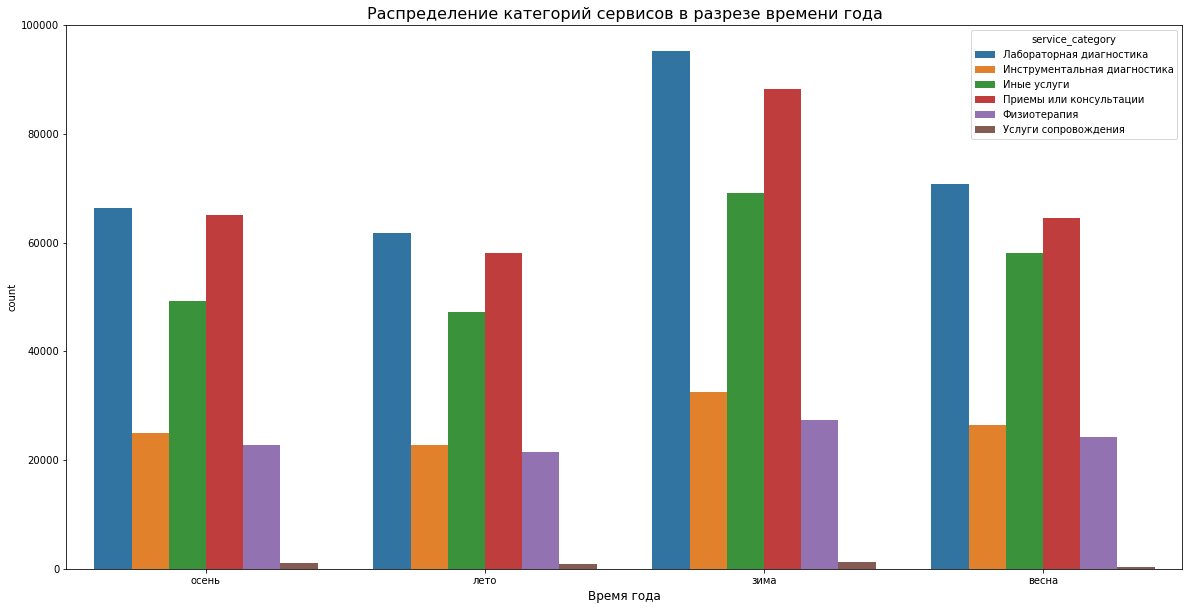

In [114]:
plt.subplots(figsize=(20, 10))

ax = sns.countplot(df['season'], hue='service_category', data=df)

ax.set_xlabel(xlabel='Время года', fontsize = 12)
ax.set_title(label='Распределение категорий сервисов в разрезе времени года', fontsize = 16)

plt.show()

Зимой спрос на любую категорию больше, чем в любое другое время года, поэтому зимой можно немного повысить цены.

Далее, обратим внимание на признак session_length, сделаем на его основе категориальный признак периода лечения.

In [115]:
def day_to_period(num:int) -> 'str':
    if num==1:
        return 'день'
    elif 1 < num <= 7:
        return 'неделя'
    elif 7 < num <= 14:
        return 'две недели'
    elif 14 < num <= 21:
        return 'три недели'
    elif 21 < num <= 31:
        return 'месяц'
    elif 31 < num:
        return 'более месяца'

In [116]:
df['period']=df['session_length'].apply(day_to_period)

c:\Users\l-pla\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


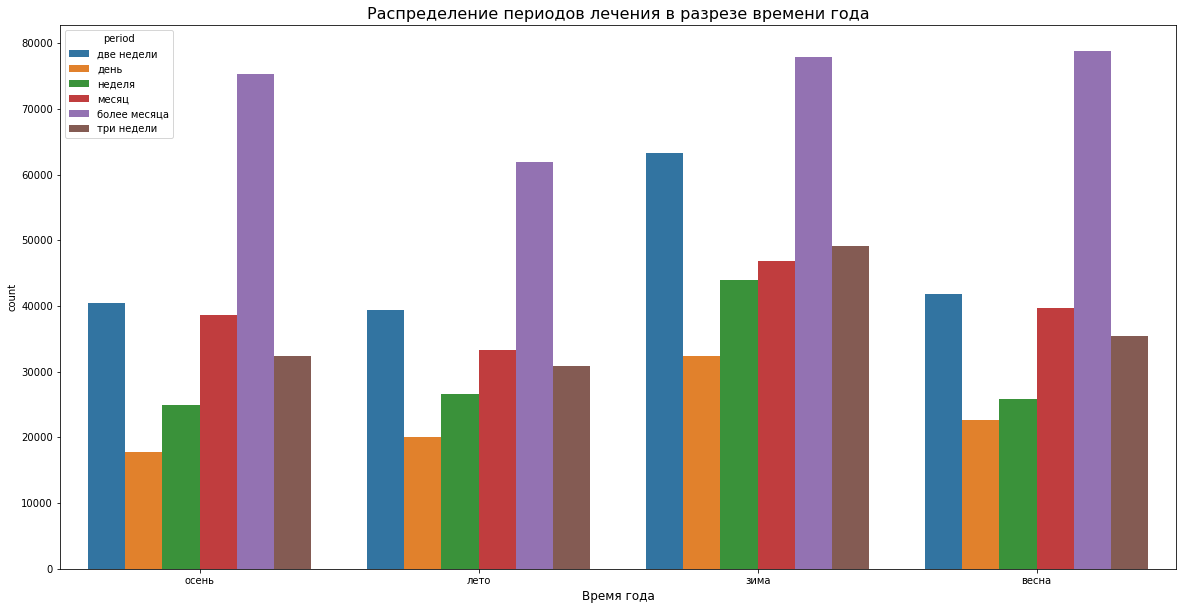

In [117]:
plt.subplots(figsize=(20, 10))

ax = sns.countplot(df['season'], hue='period', data=df)

ax.set_xlabel(xlabel='Время года', fontsize = 12)
ax.set_title(label='Распределение периодов лечения в разрезе времени года', fontsize = 16)

plt.show()

В любое время года больше всего пациентов, лечение которых занимает более месяца.

Посмотрим описательную статистику признака quantity_service

In [118]:
df['quantity_service'].describe()

count    999992.000000
mean          1.272911
std          15.458829
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max       10785.000000
Name: quantity_service, dtype: float64

Видно, что максимальное значение равно 10785, в то время как 75% квартиль равен 1.

Посмотрим диаграмму зависимости между стоймостью оказанных услуг и их количеством в разрезе периода лечения.

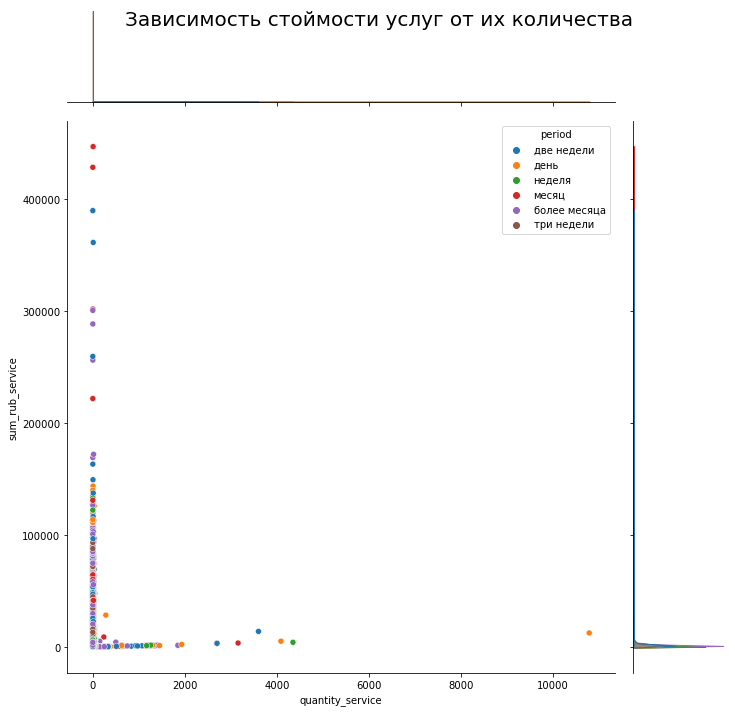

In [120]:
joint_plot = sns.jointplot(
    data=df, 
    x='quantity_service', 
    y='sum_rub_service',
    hue='period',
    height=10
)
joint_plot.fig.suptitle('Зависимость стоймости услуг от их количества', fontsize=16);

Видно, что есть много выбросов, где очень маленькая стоймость услуг, но при этом количество оказанных услуг более 1000, оказанных за очень маленькое время (день, неделя). Очевидно, это выбросы.

Прежде чем удалить эти выбросы, посмотрим на распределение целевого признака sum_rub_service. Построим две гистограммы признака: первая — в обычном масштабе, а вторая — в логарифмическом.

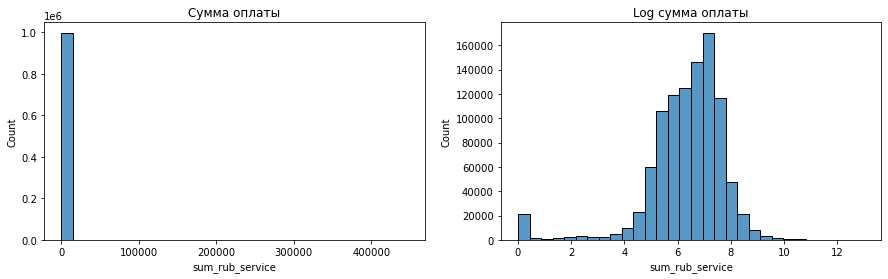

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(df['sum_rub_service'], bins=30, ax=axes[0])
histplot.set_title('Сумма оплаты');

#гистограмма в логарифмическом масштабе
log = np.log(df['sum_rub_service'] + 1)
histplot = sns.histplot(log, bins=30, ax=axes[1])
histplot.set_title('Log сумма оплаты');

Взяв натуральный логарифм, мы получаем распределение, которое напоминает слегка перекошенное нормальное. Слева от моды (самого высокого столбика) наблюдается чуть больше наблюдений, нежели справа. Распределение имеет левостороннюю асимметрию.

Напишем функцию outliers_z_score(), которая реализует алгоритм поиска выбросов при помощи метода сигм.

In [123]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.median()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_z_score(df, 'sum_rub_service', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 28417
Результирующее число записей: 971575


In [124]:
#Медианное количество процедур, которое делает пациент за сессию, которая длится более месяца
np.median(cleaned[cleaned['period']=='более месяца']['session_length'])

46.0

In [125]:
# Возьмем с запасом до 60 процедур, а остальные строки удалим 
df = cleaned[cleaned['quantity_service'] <= 60]
print(df.shape[0])

971494


Посмотрим, какие виды категорий услуг самые дорогие. Посчитаем медианную сумму услуг за периоды лечения и отобразим это в разрезе категорий сервисов. 

In [126]:
bar_data = df.groupby(
    by=['period', 'service_category'],
    as_index=False
)['sum_rub_service'].median()

c:\Users\l-pla\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


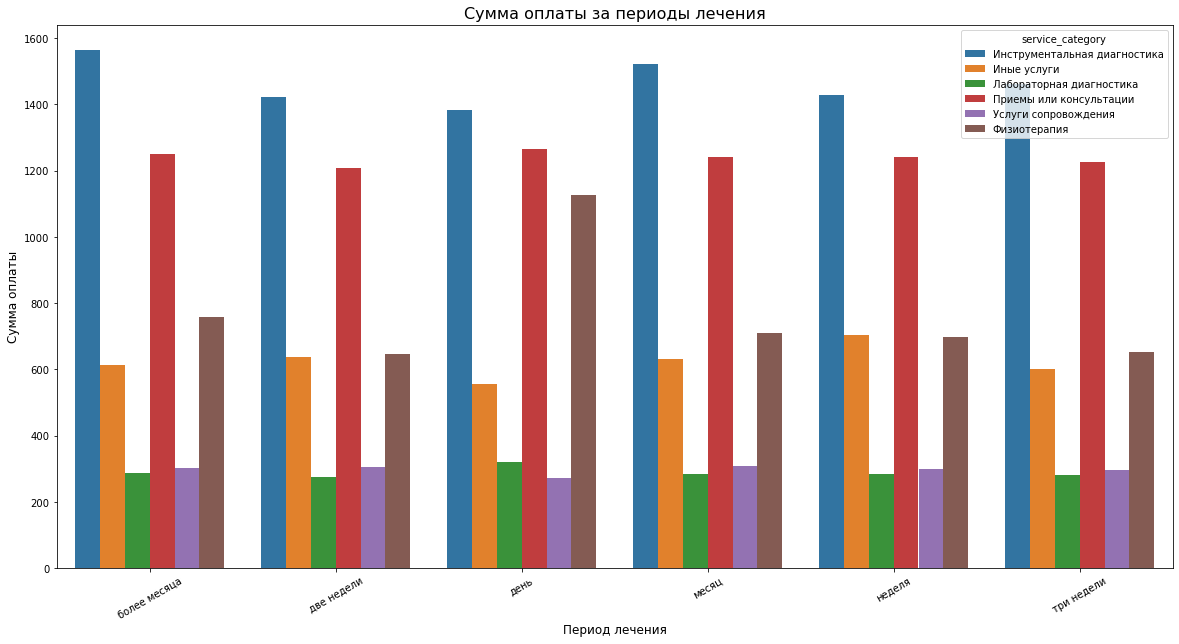

In [127]:
plt.subplots(figsize=(20, 10))

ax = sns.barplot(bar_data['period'], bar_data['sum_rub_service'], hue='service_category', data=bar_data)

ax.set_xlabel(xlabel='Период лечения', fontsize = 12)
ax.set_ylabel(ylabel='Сумма оплаты', fontsize = 12)
ax.set_title(label='Сумма оплаты за периоды лечения', fontsize = 16)
ax.xaxis.set_tick_params(rotation=30)

plt.show()

Видно, что всегда, вне зависимости от продолжения лечения, стоймости категорий инструментальной диагностики и приёмов, консультаций будут самыми дорогими, а лабораторная диагностика самая дешевая.

Посмотрим теперь зависимость среднего количества услуг за сезон обращения в разрезе субканалов оказания услуги.

In [128]:
bar_data = df.groupby(
    by=['season', 'subchannel'],
    as_index=False
)['quantity_service'].mean()

c:\Users\l-pla\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


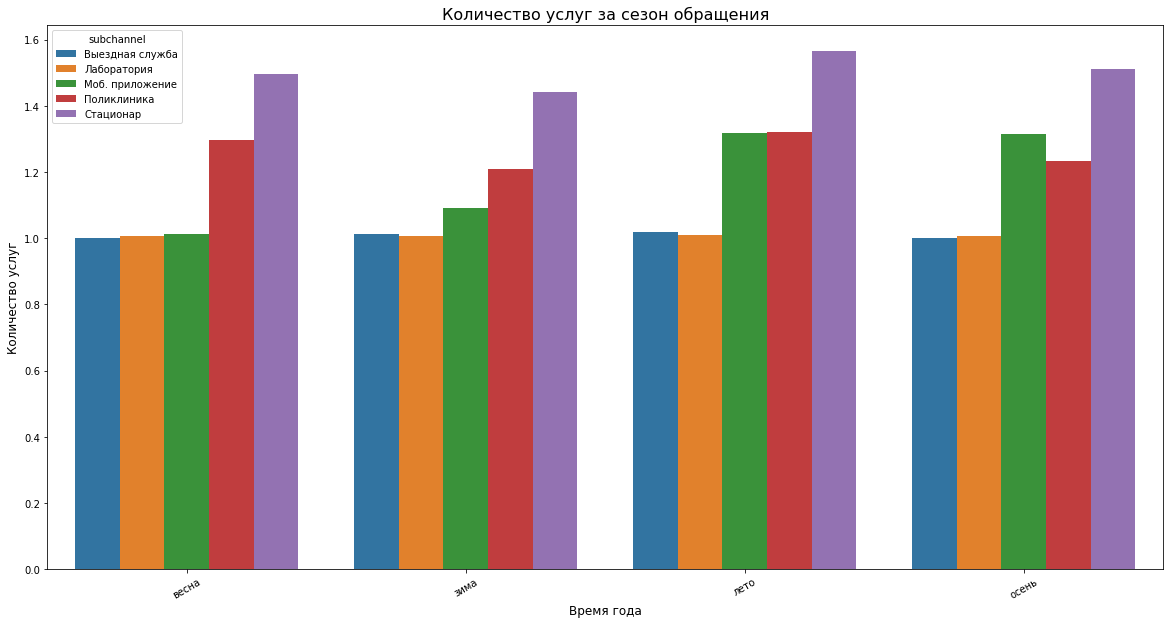

In [129]:
plt.subplots(figsize=(20, 10))

ax = sns.barplot(bar_data['season'], bar_data['quantity_service'], hue='subchannel', data=bar_data)

ax.set_xlabel(xlabel='Время года', fontsize = 12)
ax.set_ylabel(ylabel='Количество услуг', fontsize = 12)
ax.set_title(label='Количество услуг за сезон обращения', fontsize = 16)
ax.xaxis.set_tick_params(rotation=30)

plt.show()

Наибольшее количество услуг проводится в стационаре весной, летом и осенью. Летом и осенью присутствует много услуг через мобильное приложение. Так что нужно позаботиться о безошибочной работе приложения в эти времена.

#### 3.2. Кодирование признаков

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 971494 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   user_id             971494 non-null  int64 
 1   session_id          971494 non-null  object
 2   date_service        971494 non-null  object
 3   session_start_date  971494 non-null  object
 4   session_end_date    971494 non-null  object
 5   session_length      971494 non-null  int64 
 6   session_status      971494 non-null  object
 7   segment             971494 non-null  object
 8   channel             971494 non-null  object
 9   subchannel          971494 non-null  object
 10  service_category    971494 non-null  object
 11  hospital_id         971494 non-null  int64 
 12  service_rownum      971494 non-null  int64 
 13  quantity_service    971494 non-null  int64 
 14  sum_rub_service     971494 non-null  int64 
 15  season              971494 non-null  object
 16  pe

In [131]:
df[df.columns.to_list()].nunique().sort_values(ascending = False)

session_id            97144
user_id               33806
sum_rub_service       13320
hospital_id            2007
service_rownum         1303
date_service            441
session_start_date      441
session_end_date        441
session_length           62
quantity_service         49
period                    6
service_category          6
subchannel                5
season                    4
segment                   3
channel                   3
session_status            2
dtype: int64

In [132]:
# Закодируем интересующие нас категориальные признаки бинарным кодированием

nums_features_list = ['session_length', 'quantity_service', 'sum_rub_service']

cat_features_list_for_encoder = ['session_status', 'segment', 'channel', 'subchannel', 'service_category','season', 'period']

bin_encoder = ce.BinaryEncoder(cols = cat_features_list_for_encoder) 
type_bin = bin_encoder.fit_transform(df[cat_features_list_for_encoder])
df = pd.concat([df, type_bin], axis=1)
df.sample(3)

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,session_status,segment,channel,subchannel,...,subchannel_2,service_category_0,service_category_1,service_category_2,season_0,season_1,season_2,period_0,period_1,period_2
871475,141797722,141797722.1.1,2022-01-30,2022-01-28,2022-02-16,20,Completed,Не КМ,Очно,Поликлиника,...,0,1,0,0,0,1,1,1,1,0
624818,140974692,140974692.1.1,2022-01-08,2022-01-08,2022-01-08,1,Completed,Не КМ,Очно,Поликлиника,...,0,0,1,1,0,1,1,0,1,0
205399,137268894,137268894.2.1,2022-03-28,2022-03-28,2022-04-08,12,Completed,Не КМ,Очно,Поликлиника,...,0,0,1,1,1,0,0,0,0,1


#### 3.3. Удаление неинформативных признаков

In [133]:
# Удалим закодированные категориальные признаки 

df.drop(columns = cat_features_list_for_encoder, axis = 1, inplace = True)
df.sample(3)

,user_id,session_id,date_service,session_start_date,session_end_date,session_length,hospital_id,service_rownum,quantity_service,sum_rub_service,...,subchannel_2,service_category_0,service_category_1,service_category_2,season_0,season_1,season_2,period_0,period_1,period_2
248464,137984484,137984484.5.1,2022-12-10,2022-12-03,2022-12-26,24,139148110,7,1,181,...,1,0,0,1,0,1,1,1,0,0
942180,142041941,142041941.1.1,2022-03-27,2022-03-10,2022-04-11,33,141683085,26,1,1730,...,0,1,0,1,1,0,0,1,0,1
47187,1273134,1273134.2.1,2022-11-02,2022-10-31,2022-11-14,15,147598058,7,1,2776,...,1,0,1,1,0,0,1,1,1,0


In [134]:
# Удалим признаки с большим количеством уникальных значений, а также неинформативные признаки

df.drop(columns = ['user_id', 'session_id', 'date_service', 'session_start_date', 
                   'session_end_date', 'hospital_id', 
                   'service_rownum', 'date_service'], axis = 1, inplace = True)

#### 3.4. Мультиколлинеарность

<AxesSubplot:>

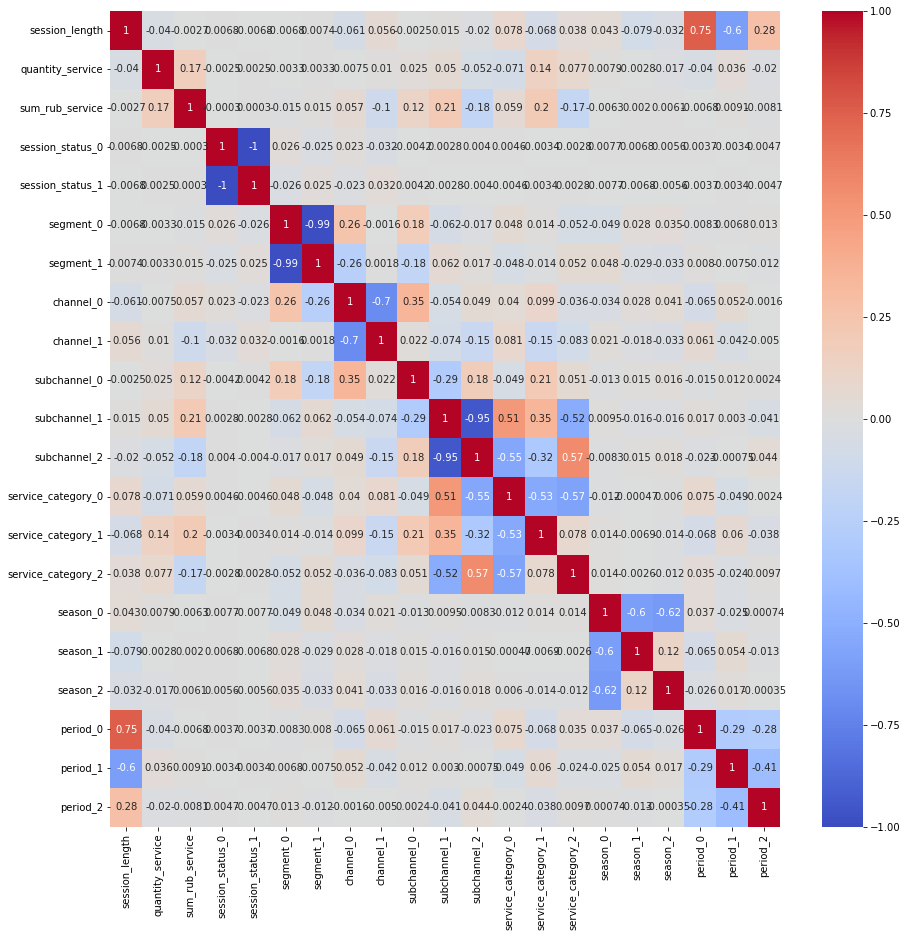

In [135]:
# Изобразим heatmap мультиколлинеарности признаков
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

Наблюдаем очень сильную корреляцию трех пар признаков: session_status_0 и session_status_1, segment_0 и segment_1, subchannel_1 и subchannel_2. Удалим по одному признаку из каждой пары. Выбирать признак для удаления будем по наименьшей коллинеарности с целевой переменной.

In [136]:
df.drop(columns = ['session_status_0', 'segment_0', 'subchannel_2'], axis = 1, inplace = True)

#### 3.5. Оценим важность признаков

<AxesSubplot:>

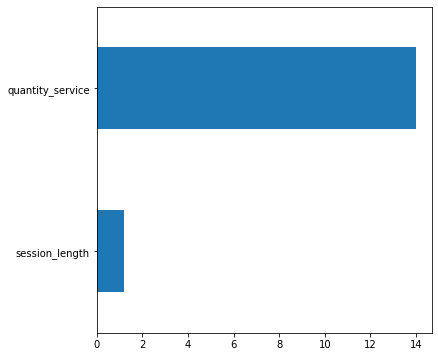

In [137]:
# Оценим значимость числовых признаков, используя тест ANOVA
nums_features_list =  ['session_length', 'quantity_service']

plt.rcParams['figure.figsize'] = (6,6)
importance_num = pd.Series(f_classif(df[nums_features_list], df.loc[:,'sum_rub_service'])[0], index = nums_features_list)
importance_num.sort_values(inplace = True)
importance_num.plot(kind = 'barh')

<AxesSubplot:>

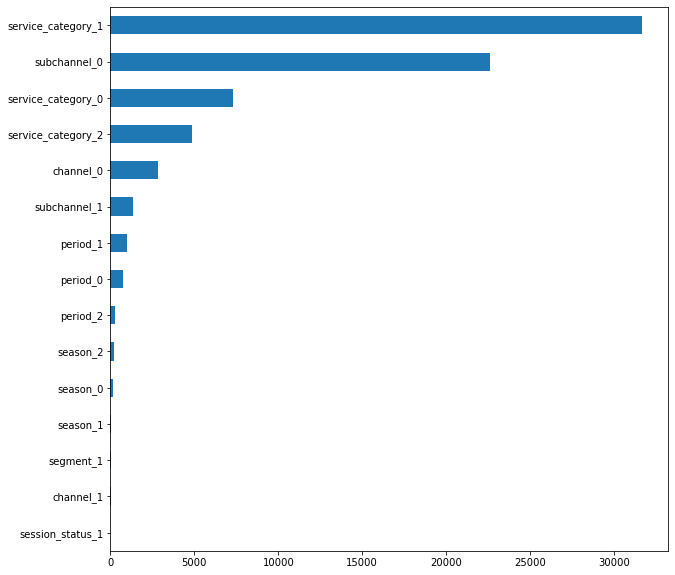

In [139]:
# Оценим значимость категориальных признаков, используя тест Хи-квадрат
cat_features_list = df.columns.to_list()[3:]

plt.rcParams['figure.figsize'] = (10,10)
importance_cat = pd.Series(chi2(df[cat_features_list], df['sum_rub_service'])[0], index=cat_features_list)
importance_cat.sort_values(inplace = True)
importance_cat.plot(kind = 'barh')

In [140]:
# Для построения модели возьмем только ТОП 11 по значимости категориальных фичей по тесту Хi^2

list_drop_cat_features = importance_cat[11:].index.to_list()
df.drop(columns = list_drop_cat_features, axis = 1, inplace = True)
df.sample(3)

,session_length,quantity_service,sum_rub_service,session_status_1,segment_1,channel_0,channel_1,subchannel_1,season_0,season_1,season_2,period_0,period_1,period_2
795074,3,1,2586,1,1,0,1,1,0,1,0,0,1,1
76585,32,1,165,1,1,0,1,0,1,0,0,1,0,1
655096,15,1,2358,1,1,0,1,1,0,1,0,1,1,0


### 4. ПОСТРОЕНИЕ МОДЕЛИ

#### 4.1. Подготовка данных для модели

In [141]:
X = df.drop(['sum_rub_service'], axis=1)
y = df['sum_rub_service']

In [142]:
# разделяем тренинговый датасет: 75% на обучение, 25% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# проверяем размерности получившихся датасетов
X.shape, X_train.shape, X_test.shape

((971494, 13), (728620, 13), (242874, 13))

#### 4.2. Построение и оценка модели линейной регрессии 

Заранее создадим функцию, которая будет расчитывать метрики:

- MAE - средняя абсолютная ошибка (целевая метрика)

- MAPE - средняя абсолютная ошибка в процентах

- R*2- коэффициент детерминации

In [143]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [144]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.077
Train MAE: 738.093
Train MAPE: 209.920


Test R^2: 0.075
Test MAE: 735.963
Train MAPE: 208.993


#### 4.3 Построение и оценка модели случайного леса

In [145]:
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
 
regr.fit(X_train, y_train) 
 
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('MAE:',metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


MAPE: 2.033542477322892
MAE: 724.4959813683362


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


<AxesSubplot:>

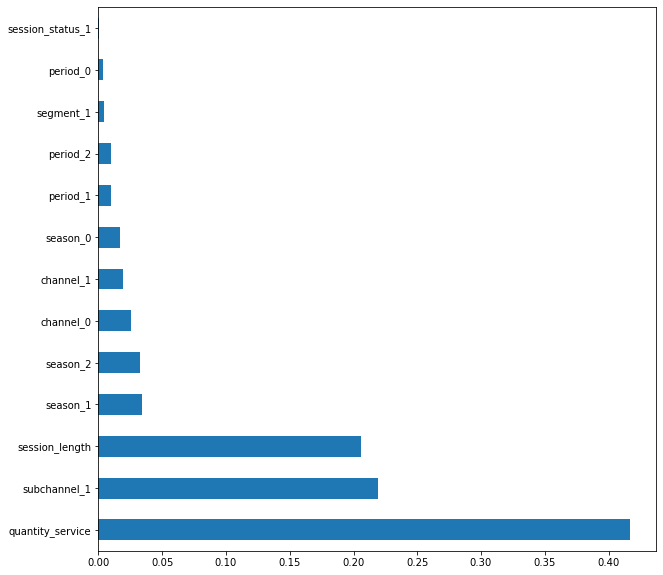

In [147]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh')

#### 4.3. Построение модели случайного леса с кросс валидацией и ее оценка

In [148]:
#Создаём объект кросс-валидатора k-fold
cv = model_selection.StratifiedKFold(n_splits=5)

In [154]:
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=regr,
    X=X_train, 
    y=y_train, 
    cv=cv,
    scoring='neg_mean_absolute_percentage_error',
    return_train_score=True 
)

c:\Users\l-pla\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out o

In [156]:
print('Train k-fold mape: {:.4f}'.format(abs(np.mean(cv_metrics['train_score']))))
print('Valid k-fold mape: {:.4f}'.format(abs(np.mean(cv_metrics['test_score']))))

Train k-fold mape: 1.9967
Valid k-fold mape: 2.0448


Ошибка на валидационной выборке 2%. Хорошая метрика.

### 5. СОХРАНЕНИЕ МОДЕЛИ

In [159]:
# Сохраним модель
joblib.dump(cv, r"cv.joblib")

['cv.joblib']